In [89]:
import numpy as np
import pymongo
import matplotlib.pyplot as plt

from io import StringIO
import json
from random import randint, random

from statistics import median, mean
import pymongo
from pysmt.smtlib.parser import SmtLibParser
from pysmt.walkers import TreeWalker, IdentityDagWalker
from pysmt.rewritings import CNFizer
from pysmt.shortcuts import *
from equiv_walker import RandomEquivDagWalker
from pysmt.exceptions import SolverReturnedUnknownResultError, NoLogicAvailableError
import tqdm
import datetime

from prop_walker import RandomWeakenerDagWalker
from strengthener_walker import RandomStrengthenerDagWalker
from symbol_walker import SymbolDagWalker



import os
import re
import sys
import time
import numpy
import requests
import traceback
import multiprocessing
import pysmt
from copy import copy


In [47]:
global mongo_connection
mongo_connection = pymongo.MongoClient("mongodb://"+"127.0.0.1"+":"+"27017", maxPoolSize=None)
global collection 
collection = mongo_connection["AUTSOFT"]["Z3"]


In [48]:
cursor = collection.find()
data = list(cursor)
print(len(data))

3050


In [49]:
#
rules_equiv = {
    #0: [array of mean differences for timing per formula, next entry]
    #1:
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[],
    10:[],
    11:[],
    12:[],
    13:[],
}
rules_weaken = {
    #0: [array of mean differences for timing per formula, next entry]
    #1:
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[],
    10:[],
    11:[],
    12:[],
    13:[],
}
rules_strength = {
    #0: [array of mean differences for timing per formula, next entry]
    #1:
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[],
    10:[],
    11:[],
    12:[],
    13:[],
}


In [50]:
test_data = data[0]


def anaylsis_for_entry(data_formula):
    orig_formula = data_formula['formula']
    entries= data_formula['data']
    
    results_equiv = copy(rules_equiv)
    results_weaken = copy(rules_weaken)
    results_strength = copy(rules_strength)
    
    results = [results_equiv,results_weaken,results_strength]
    
    for index, strategy in enumerate(entries):
        #equiv, weaken/strength, mix
        steps = strategy[0]
        should_ret = strategy[1]
        old_time = -1
        first_time = -1
        for index1, step in enumerate(steps):
            
            # formula, rule_number, sat/unsat/"unkown", walker, library_src, time in seconds
            formula,rule_number,ret_sat,walker_used,library_src,solver,time_sec = step
            if old_time == -1:
                old_time = time_sec
                first_time = old_time
                continue
           
            results[index][rule_number].append(time_sec-old_time)
            old_time = time_sec
            
    return first_time,*results
#   print(test_data)
#print(anaylsis_for_entry(test_data))

In [51]:
all_res = []
for entry in data:
    initial_time,equiv_res,weaken_res,strength_res = anaylsis_for_entry(entry)
    all_res.append(
        {
            "initial_time" :initial_time,
            "equiv_res" :equiv_res,
            "weaken_res" :weaken_res,
            "strength_res" :strength_res
        }
    )
    
# print(len(all_res))
# for key,item in all_res[-1000]['equiv_res'].items():
#     print(key)
#     print(len(item))
#print( (all_res[-1000]['equiv_res'] ))

In [52]:


equiv_rules_table_result_scatter = {
    "x":  [],
    "y":  [],
}

equiv_rules_mean = {
    "x" : [i for i in range(14)],
    "y" : [[] for i in range(14)],
}

for entry in all_res:
    equiv_res = entry['equiv_res']
    for key,value in equiv_res.items():
        #print(key)
        #equiv_rules_table_result_scatter['x'].append(key)
        equiv_rules_mean['y'][key].extend(value)

for key,row in enumerate(equiv_rules_mean['y']):
    equiv_rules_mean['y'][key] = median(row if len(row) > 0 else [0])

print(equiv_rules_mean['x'])
print(equiv_rules_mean['y'])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[-2.8371810913085938e-05, -3.7670135498046875e-05, 0, -0.0001150369644165039, -5.7697296142578125e-05, 0.003807544708251953, -0.0016551017761230469, 0, 0, 0, -1.430511474609375e-05, -8.308887481689453e-05, -0.001967191696166992, -0.00018596649169921875]


In [53]:
weaken_rules_table_result_scatter = {
    "x":  [],
    "y":  [],
}

weaken_rules_mean = {
    "x" : [i for i in range(14)],
    "y" : [[] for i in range(14)],
}

for entry in all_res:
    weaken_res = entry['weaken_res']
    for key,value in weaken_res.items():
        #print(key)
        #equiv_rules_table_result_scatter['x'].append(key)
        weaken_rules_mean['y'][key].extend(value)

for key,row in enumerate(weaken_rules_mean['y']):
    weaken_rules_mean['y'][key] = median(row if len(row) > 0 else [0])

print(weaken_rules_mean['x'])
print(weaken_rules_mean['y'])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[-0.0007582902908325195, -0.00022411346435546875, 0.0001837015151977539, 0.00013506412506103516, 0.00011229515075683594, -0.00013875961303710938, -0.00010061264038085938, 0.0007455348968505859, 0, 0, 0, 0, 0, 0]


In [54]:
strengthen_rules_table_result_scatter = {
    "x":  [],
    "y":  [],
}

strengthen_rules_mean = {
    "x" : [i for i in range(14)],
    "y" : [[] for i in range(14)],
}

for entry in all_res:
    strengthen_res = entry['strength_res']
    for key,value in strengthen_res.items():
        #print(key)
        #equiv_rules_table_result_scatter['x'].append(key)
        strengthen_rules_mean['y'][key].extend(value)

for key,row in enumerate(strengthen_rules_mean['y']):
    strengthen_rules_mean['y'][key] = median(row if len(row) > 0 else [0])

print(strengthen_rules_mean['x'])
print(strengthen_rules_mean['y'])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[-0.00014925003051757812, -0.0001876354217529297, 0.00035643577575683594, -0.0002052783966064453, 0.00029730796813964844, -0.00011730194091796875, -4.00543212890625e-05, 0.0010440349578857422, 0, 0, -2.7179718017578125e-05, -3.886222839355469e-05, 0.001940011978149414, 0]


In [91]:
equiv_rules_statistic = {
    "x" : [i for i in range(14)],
    "y" : [[] for i in range(14)],
}

for entry in all_res:
    equiv_res = entry['equiv_res']
    for key,value in equiv_res.items():
        #print(key)
        #equiv_rules_table_result_scatter['x'].append(key)
        equiv_rules_statistic['y'][key].extend(value)

weaken_rules_statistic = {
    "x" : [i for i in range(14)],
    "y" : [[] for i in range(14)],
}

for entry in all_res:
    weaken_res = entry['weaken_res']
    for key,value in weaken_res.items():
        #print(key)
        #equiv_rules_table_result_scatter['x'].append(key)
        weaken_rules_statistic['y'][key].extend(value)

strengthen_rules_statistic = {
    "x" : [i for i in range(14)],
    "y" : [[] for i in range(14)],
}

for entry in all_res:
    strengthen_res = entry['strength_res']
    for key,value in strengthen_res.items():
        #print(key)
        #equiv_rules_table_result_scatter['x'].append(key)
        strengthen_rules_statistic['y'][key].extend(value)

In [ ]:

#print("{: <5.2f}{: <5.2f}".format(1.22222,2.))

for key in range(1):
    print("Max {: <5.2f}".format(max(equiv_rules_statistic['y'][key])))
    print("Min {: <5.2f}".format(min(equiv_rules_statistic['y'][key])))
    print("Mean {: <5.2f}".format(median(equiv_rules_statistic['y'][key])))
    print("Median {: <5.2f}".format(mean(equiv_rules_statistic['y'][key])))

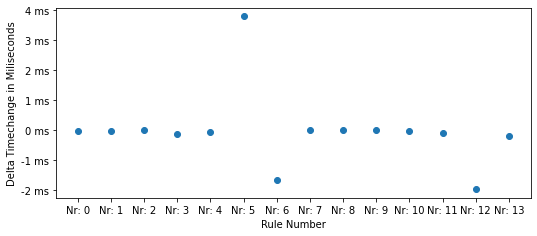

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 3.5)

capital = [ str("Nr: " + str(i)) for i in range(14)]

#print(capital)

x = equiv_rules_mean['x']
y = equiv_rules_mean['y']

ax.scatter(x,y)

ax.set_xticks(x, labels=map(str, capital))
ax.set_yticks([-0.002,-0.001,0.000,0.001,0.002,0.003,0.004], labels=map(str, ["-2 ms","-1 ms", "0 ms","1 ms","2 ms","3 ms","4 ms"]))

ax.set_ylabel('Delta Timechange in Miliseconds')
ax.set_xlabel('Rule Number')

#plt.tight_layout()
plt.show()
fig.savefig('equiv.pdf', bbox_inches='tight', facecolor='white', transparent=True, dpi=1000)

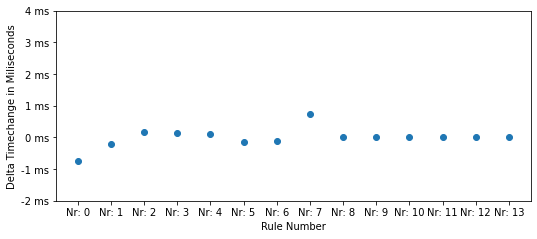

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 3.5)

capital = [ str("Nr: " + str(i)) for i in range(14)]

#print(capital)

x = weaken_rules_mean['x']
y = weaken_rules_mean['y']

ax.scatter(x,y)

ax.set_xticks(x, labels=map(str, capital))
ax.set_yticks([-0.002,-0.001,0.000,0.001,0.002,0.003,0.004], labels=map(str, ["-2 ms","-1 ms", "0 ms","1 ms","2 ms","3 ms","4 ms"]))

ax.set_ylabel('Delta Timechange in Miliseconds')
ax.set_xlabel('Rule Number')

#plt.tight_layout()
plt.show()
fig.savefig('weaken.pdf', bbox_inches='tight', facecolor='white', transparent=True, dpi=1000)

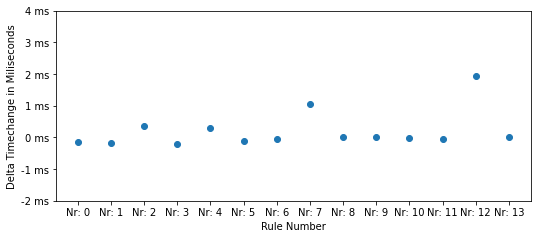

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 3.5)

capital = [ str("Nr: " + str(i)) for i in range(14)]

#print(capital)

x = strengthen_rules_mean['x']
y = strengthen_rules_mean['y']

ax.scatter(x,y)

ax.set_xticks(x, labels=map(str, capital))
ax.set_yticks([-0.002,-0.001,0.000,0.001,0.002,0.003,0.004], labels=map(str, ["-2 ms","-1 ms", "0 ms","1 ms","2 ms","3 ms","4 ms"]))

ax.set_ylabel('Delta Timechange in Miliseconds')
ax.set_xlabel('Rule Number')

#plt.tight_layout()
plt.show()
fig.savefig('strengthen.pdf', bbox_inches='tight', facecolor='white', transparent=True, dpi=1000)